# Neural Network Image Classification using Spark

****

# Imports

In [ ]:
!pip install pyspark

In [ ]:
import sys
import pyspark
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix


print("Pyspark Script:", sys.argv[0])
print("PySpark version:", pyspark.__version__)

Pyspark Script: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py
PySpark version: 3.2.1


# Download MNIST Dataset from Keras

In [ ]:
from tensorflow import keras 
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras import utils
# from tensorflow.keras.utils import to_categorical

# load MNIST
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = utils.to_categorical(y_test)


np.savetxt('sample_data/mnist_images_train.csv', x_train.reshape(len(x_train),784).tolist())
np.savetxt('sample_data/mnist_images_test.csv', x_test.reshape(len(x_test),784).tolist())
np.savetxt('sample_data/mnist_labels_train.csv', y_train.tolist())
np.savetxt('sample_data/mnist_labels_test.csv', y_test.tolist())

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# from pyspark import SparkContext
# sc =SparkContext()

# Load data

In [ ]:
txt_train_images = sc.textFile("sample_data/mnist_images_train.csv", 1)
x_train = txt_train_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_train_labels = sc.textFile("sample_data/mnist_labels_train.csv", 1)
y_train = txt_train_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_images = sc.textFile("sample_data/mnist_images_test.csv", 1)
x_test = txt_test_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_labels = sc.textFile("sample_data/mnist_labels_test.csv", 1)
y_test = txt_test_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

In [ ]:
train_ds_rdd = x_train.join(y_train).map(lambda x: x[1]).map(lambda x: (x[0], np.array([x[1][0][:2]])))
test_ds_rdd = x_test.join(y_test).map(lambda x: x[1]).map(lambda x: (x[0], np.array([x[1][0][:2]])))

train_rdd = train_ds_rdd.filter(lambda x: np.array_equal(x[1][0], [1., 0.]) or np.array_equal(x[1][0], [0., 1.]))
test_rdd = test_ds_rdd.filter(lambda x: np.array_equal(x[1][0], [1., 0.]) or np.array_equal(x[1][0], [0., 1.]))

train_rdd.cache()

print(train_rdd.take(1))
print("Trainset size:", train_rdd.count())
print("Testset size:", test_rdd.count())

[(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.05882353, 0.31764707, 0.18039216, 0.18431373,
        0.27058825, 0.10196079, 0.        , 0.        , 0.        ,
        0.00392157, 0.00392157, 0.        , 0.00392157, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00392157, 0.00784314, 0.00392157, 0.        ,
        0.        , 0.        , 0.        , 0.01176471, 0.10980392,
        0.61176473, 0.65098041, 0.65490198, 0.65490198, 0.2       ,
        0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.00392157, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00784314, 0.        , 0.        , 0.03921569, 0.14509805,
        0.22745098, 0.29803923, 0.08235294, 0.37254903, 0.96862745,
        1.        , 0.6901961 , 0.05098039, 0.

# Functions

## Activation Function

In [ ]:
# General function to apply any activation function
def activation(x, f):
    return f(x)

# Sigmoid Activation function
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

# Sigmoid prime function (used for backward prop)
def sigmoid_prime(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

## Forward Propagation

In [ ]:
# Compute the layer propagation before activation
def preforward(x, w, b):
    return np.dot(x, w) + b

# Compute the layer propagation after activation
# This is also equivalent to a predict function once model is trained
def predict(x, W1, B1, W2, B2):
    return sigmoid(preforward(sigmoid(preforward(x , W1, B1)), W2, B2))

## Backward Propagation

In [ ]:
# Compute the derivative of the error regarding B2
def derivativeB2(y_pred, y_true, y_h, f_prime):
    return (y_pred - y_true) * f_prime(y_h)

# Compute the derivative of the error regarding W2
def derivativeW2(h, dB2):
    return np.dot(h.T, dB2)

# Compute the derivative of the error regarding B1
def derivativeB1(h_h, dB2, W2, f_prime):
    return np.dot(dB2, W2.T) * f_prime(h_h)

# Compute the derivative of the error regarding W1
def derivativeW1(x, dB1):
    return np.dot(x.T, dB1)

## Evaluation

In [ ]:
def get_metrics(pred, true):
    cm = multilabel_confusion_matrix(true, pred)
    return (cm)

# Cost function
def sse(y_pred, y_true):
    return 0.5 * np.sum(np.power(y_pred - y_true, 2))

# Training (Mini Batch Implementation)

Start Training Loop:
   Epoch 1/50 | Cost: 0.29630393772009517 | Acc: 49.634160969173564 | Batchsize:8337
   Epoch 2/50 | Cost: 0.2891720066927312 | Acc: 49.610297590930564 | Batchsize:8468
   Epoch 3/50 | Cost: 0.2817160042811161 | Acc: 49.95224450811843 | Batchsize:8376
   Epoch 4/50 | Cost: 0.27278753586410626 | Acc: 50.37415369996437 | Batchsize:8419
   Epoch 5/50 | Cost: 0.2659101435941652 | Acc: 50.427350427350426 | Batchsize:8307
   Epoch 6/50 | Cost: 0.2605332743959572 | Acc: 50.15580057526366 | Batchsize:8344
   Epoch 7/50 | Cost: 0.2533595671829682 | Acc: 50.38369304556355 | Batchsize:8340
   Epoch 8/50 | Cost: 0.2437077933222879 | Acc: 51.614423756775864 | Batchsize:8486
   Epoch 9/50 | Cost: 0.23647943321115078 | Acc: 53.30790320658004 | Batchsize:8389
   Epoch 10/50 | Cost: 0.22717519284171855 | Acc: 56.520181514210655 | Batchsize:8374
   Epoch 11/50 | Cost: 0.22005938036396608 | Acc: 60.391548286976246 | Batchsize:8377
   Epoch 12/50 | Cost: 0.21380202871951556 | Acc: 65.

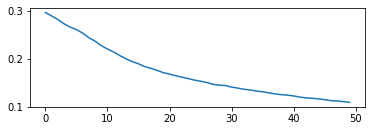

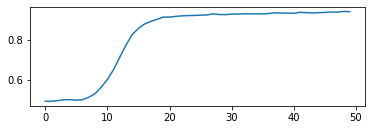

In [ ]:
# Hyperparameters
num_iteration = 50
learningRate = 0.1

input_layer = 784 # number of neurones in the input layer (equal to image size)
hidden_layer = 64 # number of neurones in the hidden layer (Custom)
output_layer = 2 # number of neurones in the output layer (equal to the number of possible labels)


# Paramater Initialization
W1 = np.random.rand(input_layer, hidden_layer) - 0.5 # Shape (784, 64)
W2 = np.random.rand(hidden_layer, output_layer) - 0.5 # Shape (64, 2)
B1 = np.random.rand(1, hidden_layer) - 0.5 # Shape (1, 64)
B2 = np.random.rand(1, output_layer) - 0.5 # Shape (1, 2)

# History over epochs
cost_history = []
acc_history = []

# Epoch Loop (mini batch implementation)
print("Start Training Loop:")

for i in range(num_iteration):
    
    # Compute gradients, cost and accuracy over mini batch 

    gradientCostAcc = train_rdd\
                        .sample(False,0.7)\
                        .map(lambda x: (x[0], preforward(x[0], W1, B1), x[1]))\
                        .map(lambda x: (x[0], x[1], activation(x[1], sigmoid), x[2]))\
                        .map(lambda x: (x[0], x[1], x[2], preforward(x[2], W2, B2), x[3]))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], activation(x[3], sigmoid), x[4]))\
                        .map(lambda x: (x[0], x[1], x[2], sse(x[4], x[5]), derivativeB2(x[4], x[5], x[3], sigmoid_prime), int(np.argmax(x[4]) == np.argmax(x[5]))))\
                        .map(lambda x: (x[0], x[1], x[3], x[4],  derivativeW2(x[2], x[4]) ,x[5]))\
                        .map(lambda x: (x[0], x[2], x[3], x[4],  derivativeB1(x[1],  x[3], W2, sigmoid_prime) ,x[5]))\
                        .map(lambda x: (x[1], x[2], x[3], x[4], derivativeW1(x[0], x[4]) ,x[5], 1)) \
                        .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3], x[4] + y[4], x[5] + y[5], x[6] + y[6]))

    # Cost and Accuarcy of the mini batch
    n = gradientCostAcc[-1] # number of images in the mini batch
    cost = gradientCostAcc[0]/n # Cost over the mini batch
    acc = gradientCostAcc[5]/n # Accuarcy over the mini batch
    
     # Add to history
    cost_history.append(cost)
    acc_history.append(acc)
    

    # Extract gradiends
    DB2 = gradientCostAcc[1]/n
    DW2 = gradientCostAcc[2]/n
    DB1 = gradientCostAcc[3]/n
    DW1 = gradientCostAcc[4]/n
            
    # Update parameter with new learning rate and gradients using Gradient Descent
    B2 -= learningRate * DB2
    W2 -= learningRate * DW2
    B1 -= learningRate * DB1
    W1 -= learningRate * DW1

    # Display performances
    print(f"   Epoch {i+1}/{num_iteration} | Cost: {cost_history[i]} | Acc: {acc_history[i]*100} | Batchsize:{n}")

print("Training end..")

# Plot of cost over epochs
plt.subplot(2, 1, 1)
plt.plot(cost_history)
plt.show()

# Plot of accuracy over epochs
plt.subplot(2, 1, 2)
plt.plot(acc_history)
plt.show()

# Test Evaluation

In [ ]:
# Use the trained model over the Testset and get Confusion matrix per class
metrics = test_rdd.map(lambda x: get_metrics(np.round(predict(x[0], W1, B1, W2, B2)), x[1]))\
                  .reduce(lambda x, y: x + y)

# For each class give TP, FP, FN, TN and precision, and recall, and F1 score
for label, label_metrics in enumerate(metrics):
    
    print(f"\n---- Digit {label} ------\n")
    tn, fp, fn, tp = label_metrics.ravel()
    print("TP:", tp, "FP:", fp, "FN:", fn, "TN:", tn)

    precision = tp / (tp + fp + 0.000001)
    print(f"\nPrecision : {precision}")

    recall = tp / (tp + fn + 0.000001)
    print(f"Recall: {recall}")

    F1 = 2 * (precision * recall) / (precision + recall + 0.000001)
    print(f"F1 score: {F1}")


---- Digit 0 ------

TP: 924 FP: 97 FN: 76 TN: 903

Precision : 0.9049951019539715
Recall: 0.9239999990760001
F1 score: 0.9143983116184361

---- Digit 1 ------

TP: 924 FP: 63 FN: 76 TN: 937

Precision : 0.9361702118174567
Recall: 0.9239999990760001
F1 score: 0.93004479349923


In [ ]:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

pred: 1, prob: 0.79 true: 1


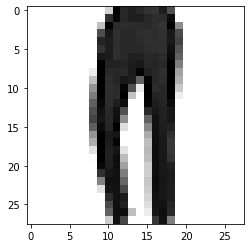

pred: 1, prob: 0.66 true: 1


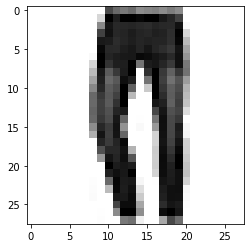

pred: 0, prob: 0.57 true: 0


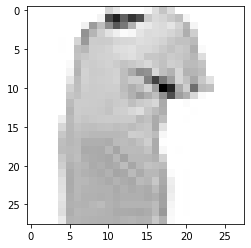

pred: 1, prob: 0.81 true: 1


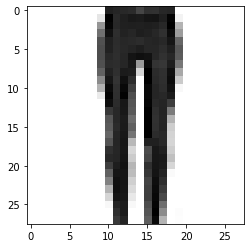

pred: 0, prob: 0.57 true: 0


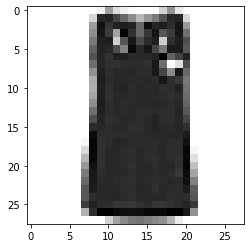

pred: 0, prob: 0.68 true: 0


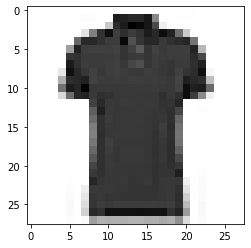

pred: 0, prob: 0.69 true: 0


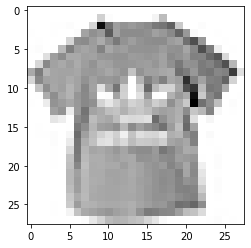

pred: 0, prob: 0.75 true: 0


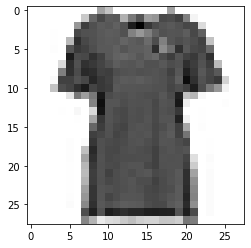

pred: 1, prob: 0.51 true: 1


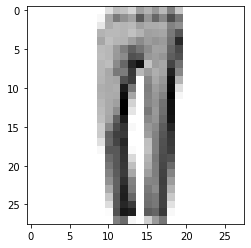

pred: 0, prob: 0.83 true: 0


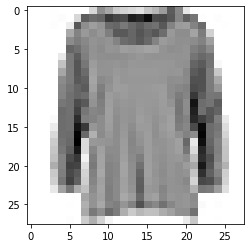

In [ ]:
# Display some Images for checking
for image_test in test_rdd.map(lambda x: (x[0], predict(x[0], W1, B1, W2, B2), np.argmax(x[1]))).takeSample(False, 10):
    
    pred = np.argmax(image_test[1])
    print(f'pred: {pred}, prob: {round(image_test[1][0][pred], 2)} true: {image_test[2]}')
    image = np.reshape(image_test[0], (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()

# Thank you !